# Multiplexing signals and generating AM signal

In [1]:
import numpy as np
import scipy.io.wavfile as iowav
from scipy import signal
import resampy
import matplotlib.pyplot as plt
import wave as wv

Fs Audio 1:  8000 
Fs Audio 2:  8000


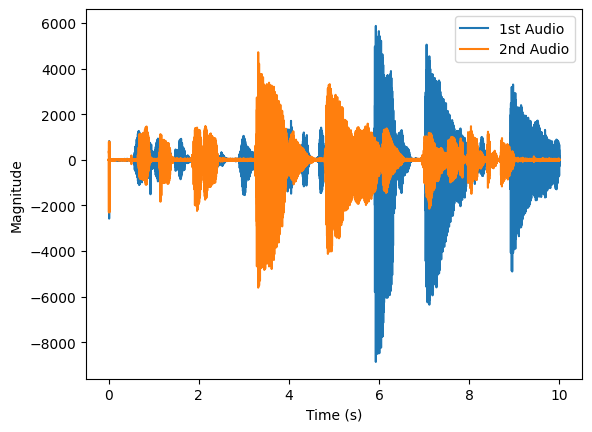

In [2]:
[Fs1, audio1] = iowav.read('../data/audio1.wav')
[Fs2, audio2] = iowav.read('../data/audio2.wav')
t = 10 # 10 seconds of audio
audio1 = audio1[0:t*Fs1]
audio2 = audio2[0:t*Fs2]
print("Fs Audio 1: ",Fs1,"\nFs Audio 2: ",Fs2)
plt.figure()
plt.plot(np.arange(len(audio1))/Fs1, audio1, label="1st Audio")
plt.plot(np.arange(len(audio2))/Fs2, audio2, label="2nd Audio")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.show()

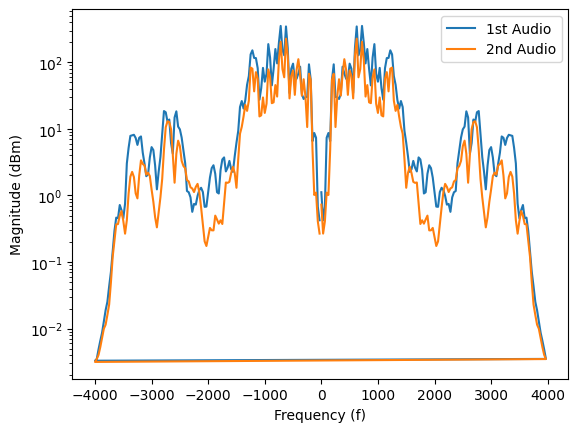

In [3]:
# Plot signal power and frequencies
xf1, yp1 = signal.welch(audio1, Fs1, return_onesided=False)
xf2, yp2 = signal.welch(audio2, Fs2, return_onesided=False)
plt.figure()
plt.semilogy(xf1, yp1, label="1st Audio")
plt.semilogy(xf2, yp2, label="2nd Audio")
plt.legend()
plt.xlabel("Frequency (f)")
plt.ylabel("Magnitude (dBm)")
plt.show()

Now let's analyze it using digital frequency, so let's remember the continuous to discrete frequency conversion:
$$ \omega=\Omega F_s $$
remembering that $\omega$ represents the continuous angular frequency in $\mathit{rad}/s$, $\Omega$ represents the discrete frequency in $\mathit{rad}$, and $F_s$ is the sampling frequency. We can also map the continuous angular frequency from $\mathit{rad}/s$ to $Hz$ using the relation $\omega=2\pi f$. Therefore, as we are representing our signal in $Hz$, we can calculate:
$$\Omega = \omega/F_s $$
$$\Omega = \frac{2\pi f}{F_s}$$
and now we have established a relation between the frequency in $Hz$ to a discrete frequency $\Omega$ in $\mathit{rad}$.

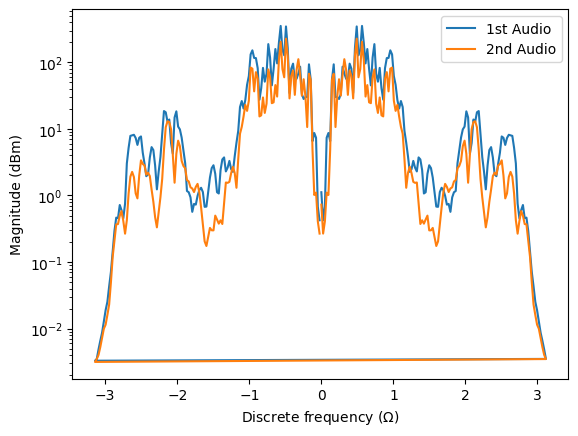

In [4]:
xf1_digi, yp1_digi = signal.welch(audio1, Fs1, return_onesided=False)
xf2_digi, yp2_digi = signal.welch(audio2, Fs2, return_onesided=False)
plt.figure()
plt.semilogy(2*np.pi*xf1_digi/Fs1, yp1_digi, label="1st Audio") # We are converting frequency in Hz to discrete frequency in rad
plt.semilogy(2*np.pi*xf2_digi/Fs2, yp2_digi, label="2nd Audio")
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

The maximum frequency of both audios is $f_{\mathit{max}}=4000Hz$ which is exactly the limit of the Nyquist sampling frequency $F_s/2 = 8000/2 = 4000 Hz$. Therefore we can calculate where $f_{\mathit{max}}$ will be mapped in the discrete domain $\Omega$ using:
$$ \Omega = \frac{2\pi f_{\mathit{max}}}{Fs} $$
$$ \Omega = \frac{2\pi f_{\mathit{max}}}{2f_{\mathit{max}}} $$
$$ \Omega = \pi $$

That's the reason why the frequency $4000 Hz$ was mapped to exactly $\pi=3.1415$ in the graph above.

An interesting aspect to take in consideration in the discrete domain is the copies of the signal that will appear in every $k 2 \pi$, so let's take a look at our signal considering these copies:

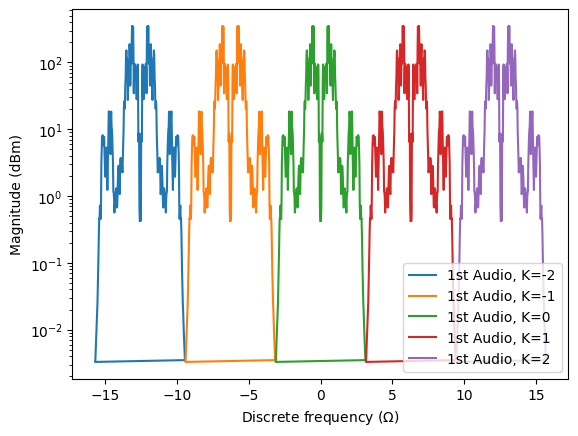

In [5]:
xf1_copies, yp1_copies = signal.welch(audio1, Fs1, return_onesided=False)
num_copies = 2
plt.figure()
for k in np.arange(-1*num_copies, num_copies+1):
	plt.semilogy(k*2*np.pi+2*np.pi*xf1_copies/Fs1, yp1_copies, label=f"1st Audio, K={k}") # We are including K in the x-axis
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

The distance between copies of our signal are too close to each other that may cause troubles to filter or even generate inter-symbol interference (ISI) during the transmission. So, it is a good call to try to "separate" the copies by increasing the sampling frequency $F_s$ (we call it upsampling).

## Upsampling

In the upsampling process we increase the number of samples in our signal, reducing the bandwidth in the frequency domain, hence increasing the distance between the signal copies. We also filter the signal after since now the distance between copies are higher, and it is easy to project a filter to attend this new requirements.

We start creating `upsample_prefilter` and `downsample_prefilter` functions to insert/remove zeros from the signal (without filter) as depicted below.

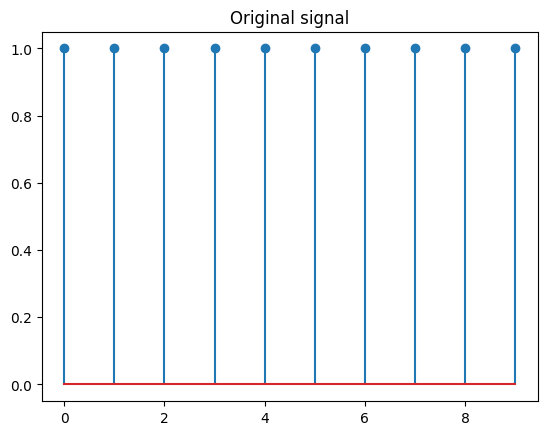

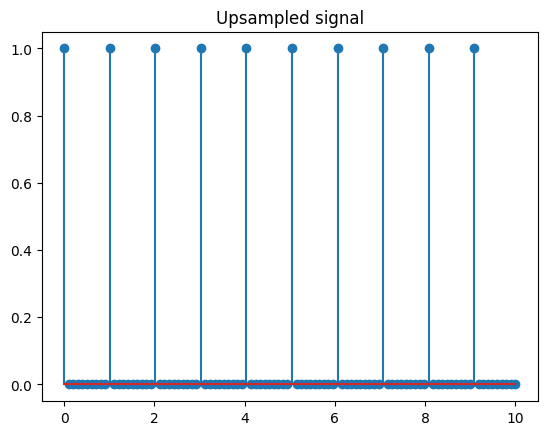

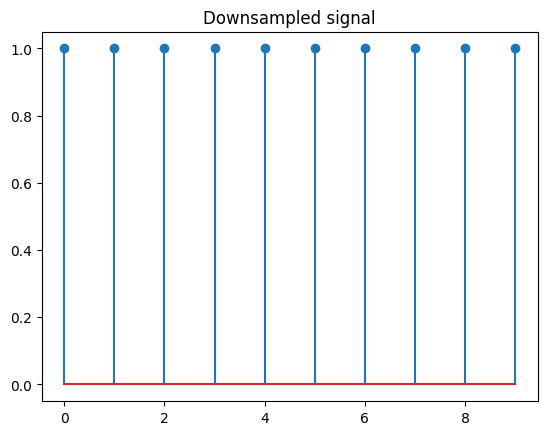

In [6]:
def upsample_prefilter(vector, factor):
	new_vector = np.zeros(len(vector)*factor, dtype=audio1.dtype)
	new_vector[::factor] = vector

	return new_vector

def downsample_prefilter(vector, factor):
	new_vector = vector[::factor]

	return new_vector

test = np.ones(10)
plt.figure()
plt.stem(test)
plt.title("Original signal")
plt.show()

U = 10
upsampled_test = upsample_prefilter(test, U)
plt.figure()
plt.stem(np.linspace(0,len(test), len(upsampled_test)), upsampled_test)
plt.title("Upsampled signal")
plt.show()

D=U
downsampled_test = downsample_prefilter(upsampled_test, D)
plt.figure()
plt.stem(np.linspace(0,len(test)-1, len(downsampled_test)), downsampled_test)
plt.title("Downsampled signal")
plt.show()

Now we apply our `upsample` function to the signal:

In [7]:
# Resampling signal
U = 10 # Upsampling factor
Fs_tx = U*Fs1
audio1_resampled_pre_filter = upsample_prefilter(audio1, U)
audio2_resampled_pre_filter = upsample_prefilter(audio2, U)

Using the upsampĺing factor as $U=10$, we have reduced the original signal bandwidth by 10 times. So the bandwidth of $4kHz$ (or $\pi$) from the original signal was reduced to $4000/10=400Hz$ (or $\pi/10=0.314$).

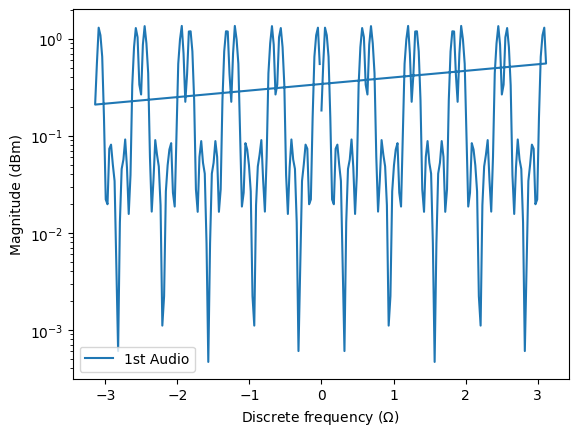

In [8]:
xf1_resample_pre_filter, yp1_resample_pre_filter = signal.welch(audio1_resampled_pre_filter, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(2*np.pi*xf1_resample_pre_filter/Fs_tx, yp1_resample_pre_filter, label="1st Audio")
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

The upsampling increase the number of samples in our signal (different techniques could be applied to defined what should be the values of these new samples), so let's verify how this could affect the energy and power of our discrete signal. The energy of a discrete signal can be defined as:
$$\sum_{n=0}^{N-1}{|x^2|}$$

where $N$ is the total number of samples and $x$ refers to our audio signal. Therefore (considering that the audio values are given in Volts):

In [9]:

energy_signal = np.sum(np.power(audio1,2))
energy_resampled_signal = np.sum(np.power(audio1_resampled_pre_filter,2))
print(f"Audio 1 energy: {energy_signal} J\nAudio 1 resampled energy: {energy_resampled_signal} J")

Audio 1 energy: 153463884 J
Audio 1 resampled energy: 153463884 J


So the upsampling increased kept the same energy from previous signal. Now, let's take a look in our signal power (average energy since we are dealing with discrete signal):
$$ P_s = E_{avg} = \frac{\sum_{n=0}^{N-1}{|x^2|}}{N}$$

Therefore, the power can be calculated as:

In [10]:
avg_energy_signal = np.mean(np.power(audio1,2))
avg_energy_resampled_signal = np.mean(np.power(audio1_resampled_pre_filter,2))
print(f"Audio 1 Avg energy: {avg_energy_signal} J/sample\nAudio 1 resampled Avg energy: {avg_energy_resampled_signal} J/sample")

Audio 1 Avg energy: 1918.29855 J/sample
Audio 1 resampled Avg energy: 191.829855 J/sample


The Energy stills the same, but the average energy decreased by 10 times due to insertion of zero values.

Besides the bandwidth reduction, copies of the original signal appeared on both sides, therefore we need to filter the signal to eliminate copies (creating a low-pass filter with bandwidth of $400Hz$ or $\pi/10 = 0.31415$ rad).

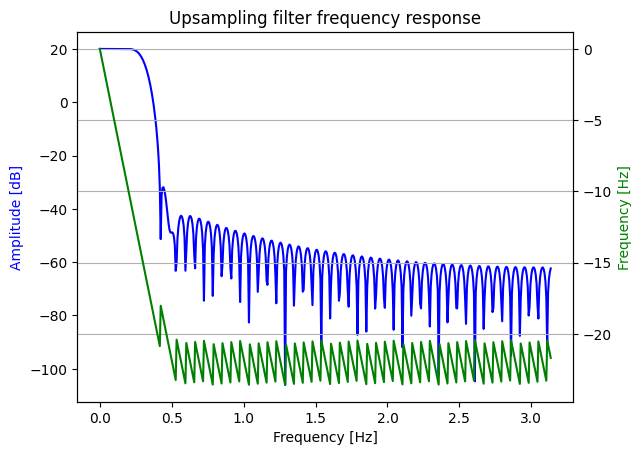

Group Delay:  50.0


In [11]:
# Upsampling filter
Foff = (np.pi/U)/np.pi # Filter cutoff frequency normalized by pi
filter_taps = 101
B_upsampling = U*signal.firwin(filter_taps,Foff, window = "hamming")
w, h = signal.freqz(B_upsampling)
fig, ax1 = plt.subplots()
ax1.set_title('Upsampling filter frequency response')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Frequency [Hz]', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()
group_delay = signal.group_delay((B_upsampling, 1))[1][0]
print('Group Delay: ', group_delay)

In order to better understand the group delay, let's change our first signal sample value [0] from 0 to 1000.

Previous value [0]: 0
New value [0]: 1000


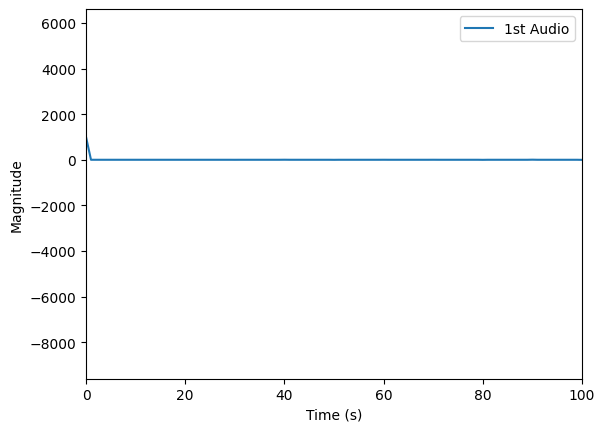

In [12]:
print(f"Previous value [0]: {audio1_resampled_pre_filter[0]}")
audio1_resampled_pre_filter[0] = 1000
print(f"New value [0]: {audio1_resampled_pre_filter[0]}")
plt.figure()
plt.plot(audio1_resampled_pre_filter, label="1st Audio")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.xlim([0,100])
plt.show()

Filtering the signal, we obtain:

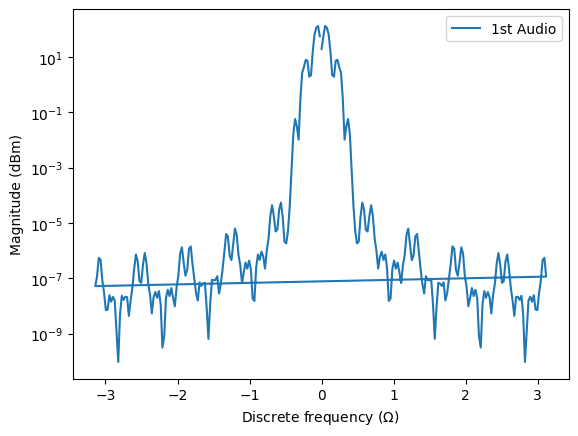

In [13]:
# Apply the filter to upsampled signals
audio1_resampled = signal.lfilter(B_upsampling, 1, audio1_resampled_pre_filter)
audio2_resampled = signal.lfilter(B_upsampling, 1, audio2_resampled_pre_filter)

xf1_resample, yp1_resample = signal.welch(audio1_resampled, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(2*np.pi*xf1_resample/Fs_tx, yp1_resample, label="1st Audio")
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

Now, let's observe the delay implications in our signal:

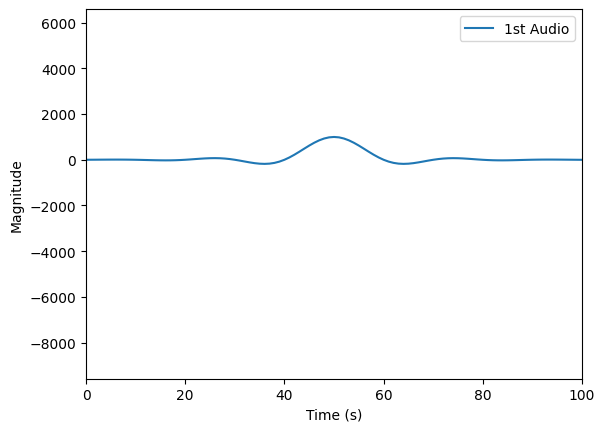

In [14]:
plt.figure()
plt.plot(audio1_resampled, label="1st Audio")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.xlim([0,100])
plt.show()

In the graph above we can perceive that our signal was delayed by about 50 samples which is exactly the effect of the group delay due to our causal filter. Therefore we need to remove this delay inserted by the filter to go ahead.

# Fixing group delay

Attention to our signal length:

In [15]:
print(len(audio1_resampled))

800000


Here we will apply a simple process to realign our signal by removing the inserted delay. It is important to emphasize that more intelligent methods could be used such as using [filtfilt function](https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.filtfilt.html), but here we are focusing on keep it simple and transparent. In accordance with Fourier properties: $$x[n-D] \Longleftrightarrow e^{\frac{-j2\pi kD}{N}}X[k] = X_{\mathrm{delay}}[k].$$
Therefore, a delay of $D$ in the time-domain generates a phase in the frequency domain equals to $e^{\frac{-j2\pi kD}{N}}$. In order to realign the signal (remove the inserted delay), we can divide the delayed signal in the frequency domain by the inserted phase $$ X[k] = \frac{X_{\mathrm{delay}}[k]}{e^{\frac{-j2\pi kD}{N}}}$$

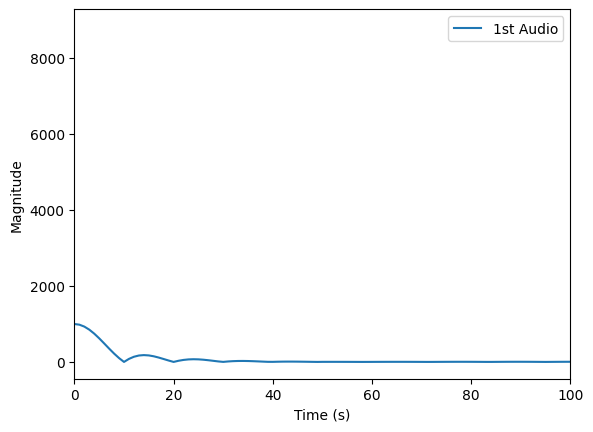

In [16]:
def rm_transient(x, group_delay):
	tmp_x = np.fft.fft(x)/np.exp(-1j*2*np.pi*group_delay*np.arange(len(x))/len(x)) # Here we make the calculation described above
	return np.fft.ifft(tmp_x)
audio1_resampled = rm_transient(audio1_resampled, group_delay)
audio2_resampled = rm_transient(audio2_resampled, group_delay)

plt.figure()
plt.plot(abs(audio1_resampled), label="1st Audio")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Magnitude")
plt.xlim([0,100])
plt.show()

We will recover the original signal 1 without the value sample[0]=1000

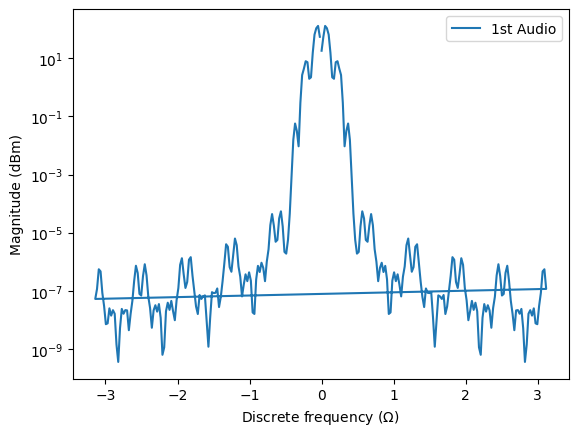

In [17]:
audio1_resampled_pre_filter = upsample_prefilter(audio1, U)
audio1_resampled = signal.lfilter(B_upsampling, 1, audio1_resampled_pre_filter)
audio1_resampled = rm_transient(audio1_resampled, group_delay)
xf1_resample, yp1_resample = signal.welch(audio1_resampled, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(2*np.pi*xf1_resample/Fs_tx, yp1_resample, label="1st Audio")
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

## Creating the AM signal

In [18]:
# Multiplexing signals x1 and x2 into x considering carrier frequencies 610kHz and 620kHz, respectively
carriers = np.array([15, 30]) * 1e3
h = 0.5
n = np.arange(0, t, 1/Fs_tx)
A1 = np.max(np.abs(audio1_resampled))/h
A2 = np.max(np.abs(audio2_resampled))/h
phase = np.pi
x = (A1+audio1_resampled)*np.cos(2*np.pi*n*carriers[0]+phase)+(A2+audio2_resampled)*np.cos(2*np.pi*n*carriers[1]+phase)

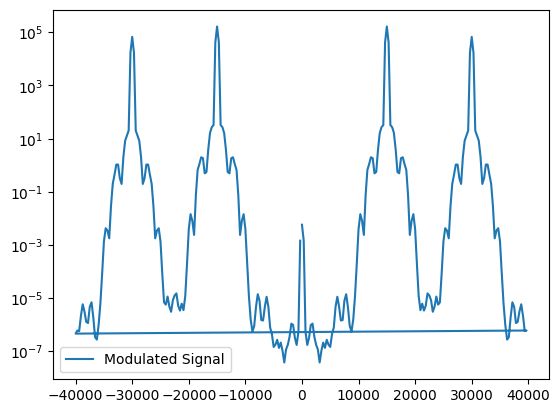

In [19]:
fmodx, ymodx = signal.welch(x, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(fmodx, ymodx, label="Modulated Signal")
plt.legend()
plt.show()

In [20]:
# Creating a noise in according to SNR value and inserting into signal x
SNR_db = 40
power_x = np.mean(np.power(x,2))
noise = np.sqrt(power_x/(np.power(10,SNR_db/10)))*np.random.randn(len(x))
noise_power = np.mean(np.power(noise,2))
rx = x+noise
print(10*np.log10(power_x/noise_power))

(40.00332684683096-3.2656503729532014e-32j)


# Demodulating AM signal (Superheterodyne)

We assume an intermediate frequency `if=8kHz` that will contain a pass-band filter with a bandwidth of $8$ kHz. Hence, we need to transport our signal from carrier frequencies to the IF frequency first.

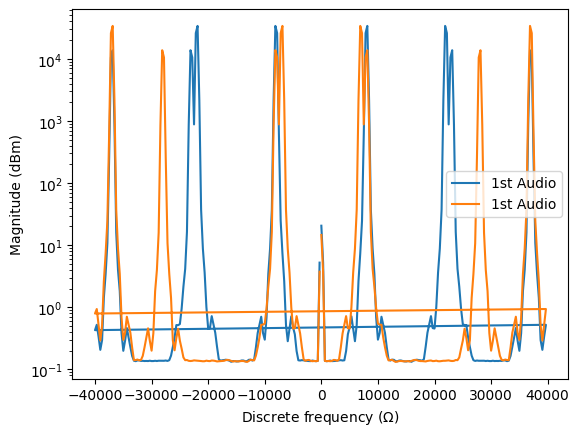

In [21]:
# Downconversion to the IF frequency
if_c = 8e3
rif1 = rx*np.cos(2*np.pi*n*(carriers[0]-if_c)+phase)
rif2 = rx*np.cos(2*np.pi*n*(carriers[1]-if_c)+phase)

xf_rif1, yp_rif1 = signal.welch(rif1, Fs_tx, return_onesided=False)
xf_rif2, yp_rif2 = signal.welch(rif2, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(xf_rif1, yp_rif1, label="1st Audio")
plt.semilogy(xf_rif2, yp_rif2, label="1st Audio")
plt.legend()
plt.xlabel(r"Discrete frequency ($\Omega$)")
plt.ylabel("Magnitude (dBm)")
plt.show()

The filter in the intermediate frequency is centered on `if=8kHz` and has a bandwidth of $8$ KHz. Therefore, the filter starts at $8-4=4$ kHz and ends at $8+4=12$ kHz.

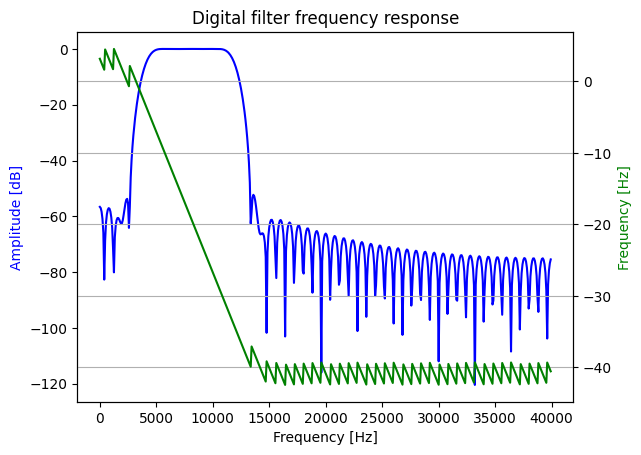

Group Delay:  49.99999999999754


In [22]:
# Intermediate frequency (IF) filter
start_cut = 4e3 # IF - bandwidth
stop_cut = 12e3 # IF - bandwidth
B_if = signal.firwin(numtaps=101, cutoff=[start_cut, stop_cut], pass_zero=False, window="hamming", fs=Fs_tx)
w, h = signal.freqz(B_if, fs=Fs_tx)
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Frequency [Hz]', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()
print('Group Delay: ', signal.group_delay((B_if, 1))[1][0])

Below, the IF filter is applied on our signal, removing copies.

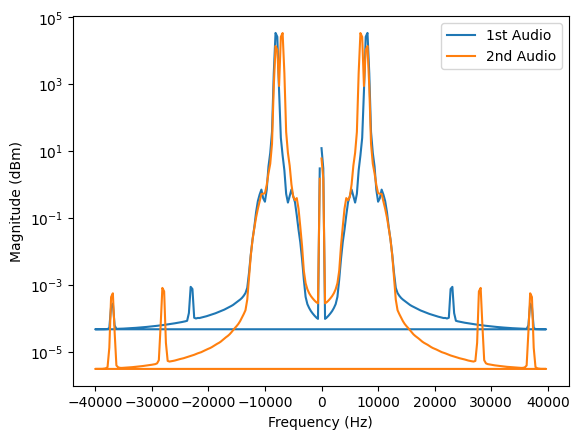

In [23]:
rif1_filtered = signal.lfilter(B_if, 1, rif1)
rif1_filtered = rm_transient(rif1_filtered, group_delay)
rif2_filtered = signal.lfilter(B_if, 1, rif2)
rif2_filtered = rm_transient(rif2_filtered, group_delay)
xf_rif1_filtered, yf_rif1_filtered = signal.welch(rif1_filtered, Fs_tx, return_onesided=False)
xf_rif2_filtered, yf_rif2_filtered = signal.welch(rif2_filtered, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(xf_rif1_filtered, yf_rif1_filtered, label="1st Audio")
plt.semilogy(xf_rif2_filtered, yf_rif2_filtered, label="2nd Audio")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dBm)")
plt.show()

Now let's implement an AM detector to bring our signals to the baseband. The envelope detection is implemented squaring and low-pass filtering the signal in accordance with [Matlab explanation](https://www.mathworks.com/help/dsp/ug/envelope-detection.html;jsessionid=c1c36ae08534b92b8ca68f6edc58). When the filtered signal in the IF frequency is squared we obtain the following: $$r^2=[(A+h)\cos(2\pi f_c t+\phi)]^2 \\ r^2=(A+h)^2\cos^2(2\pi f_c t+\phi).$$ Using the property $\cos^2(x)=\frac{1+\cos(2x)}{2}$, we obtain $$r^2=(A+h)^2[\frac{1}{2}+\frac{\cos(2\cdot (2\pi f_c t +\phi))}{2}] \\ \\ r^2=\frac{(A+h)^2}{2}+\frac{(A+h)^2\cos(2\cdot 2\pi f_c t + 2\phi))}{2}.$$ Our result has two components. The second component (term in the right side) has 2 times the frequency $f_c$ of the original signal. While, the first component is a signal in the baseband. Therefore, we can filter the signal that is not in the baseband and recover our original signal.

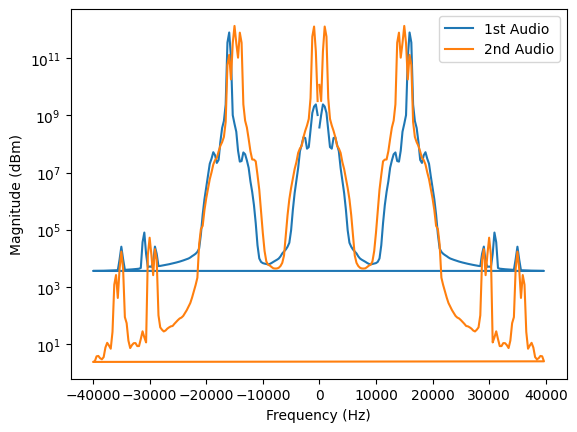

In [24]:
# Squaring the received signals
rbb1_squared = np.power(rif1_filtered, 2)
rbb2_squared = np.power(rif2_filtered, 2)
xf_rbb1_squared, yf_rbb1_squared = signal.welch(rbb1_squared, Fs_tx, return_onesided=False)
xf_rif2_squared, yf_rbb2_squared = signal.welch(rbb2_squared, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(xf_rbb1_squared, yf_rbb1_squared, label="1st Audio")
plt.semilogy(xf_rif2_squared, yf_rbb2_squared, label="2nd Audio")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dBm)")
plt.show()

Now let's apply a baseband filter with $4$ kHz bandwidth (in baseband) to filter the copies generated after the squaring process.

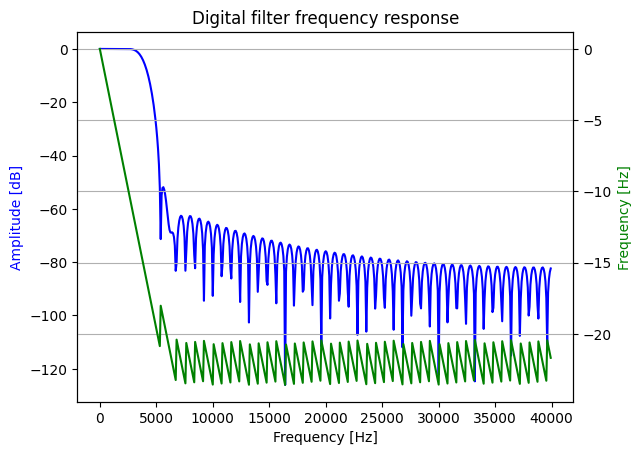

Group Delay:  50.00000000000001


In [25]:
# Filtering the upsampled signal at baseband
Foff = 4e3 # Filter cutoff frequency considering the upsampling factor
filter_taps = 101
B_bb = signal.firwin(filter_taps, Foff, fs=Fs_tx, window = "hamming")
w, h = signal.freqz(B_bb, fs=Fs_tx)
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Frequency [Hz]', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()
print('Group Delay: ', signal.group_delay((B_bb, 1))[1][0])

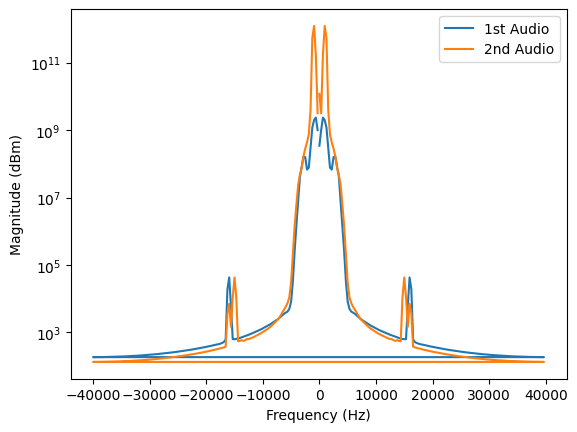

In [26]:
# Filtering the signal
rbb1_filtered = signal.lfilter(B_bb, 1, rbb1_squared)
rbb1_filtered = rm_transient(rbb1_filtered, group_delay)
rbb2_filtered = signal.lfilter(B_bb, 1, rbb2_squared)
rbb2_filtered = rm_transient(rbb2_filtered, group_delay)
xf_rbb1_filtered, yf_rbb1_filtered = signal.welch(rbb1_filtered, Fs_tx, return_onesided=False)
xf_rbb2_filtered, yf_rbb2_filtered = signal.welch(rbb2_filtered, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(xf_rbb1_filtered, yf_rbb1_filtered, label="1st Audio")
plt.semilogy(xf_rbb2_filtered, yf_rbb2_filtered, label="2nd Audio")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dBm)")
plt.show()

Looking the figure above, you can compare with the signal obtained after the filtering process on the IF frequency. You will perceive that the signal has a greater magnitude now because it is: $$r^2=\frac{(A+h)^2}{2}.$$ So, in order to recover our exact signal we need to multiply by two and take the squared root of it to obtain $(A+h)$:$$\sqrt{2r^2}=A+h.$$

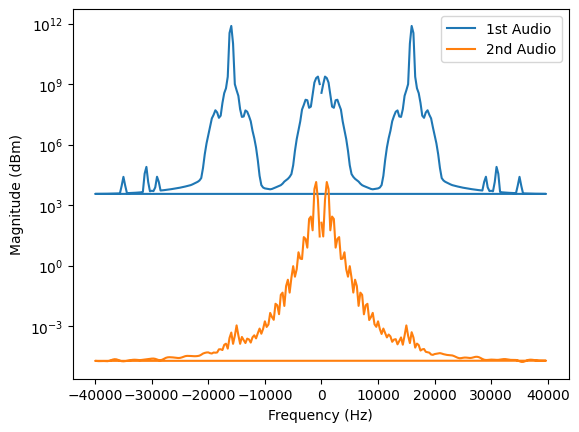

In [27]:
# multiplying by two and taking the squared root
rbb1_recover = np.sqrt(2*rbb1_filtered)
rbb2_recover = np.sqrt(2*rbb2_filtered)
xf_rbb1_recover, yf_rbb1_recover = signal.welch(rbb1_recover, Fs_tx, return_onesided=False)
xf_rif2_recover, yf_rbb2_recover = signal.welch(rbb2_recover, Fs_tx, return_onesided=False)
plt.figure()
plt.semilogy(xf_rbb1_recover, yf_rbb1_squared, label="1st Audio")
plt.semilogy(xf_rif2_recover, yf_rbb2_recover, label="2nd Audio")
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dBm)")
plt.show()

In [ ]:
# Filtering the upsampled signal at baseband
Foff = 4e3 # Filter cutoff frequency
filter_taps = 101
B_bb = signal.firwin(filter_taps,Foff/(Fs_tx/2), window = "hamming")
w, h = signal.freqz(B_bb)
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')
ax1.plot(w*Fs1/(2*np.pi), 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w*Fs1/(2*np.pi), angles, 'g')
ax2.set_ylabel('Frequency [Hz]', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()
print('Group Delay: ', signal.group_delay((B_bb, 1))[1][0])

In [ ]:
# Apply the filter on received signals with upsampling
rbb1 = signal.lfilter(B, 1, rbb1)
rbb2 = signal.lfilter(B, 1, rbb2)

# Resampling signals to 8kHz
rbb1_resampled = downsample_prefilter(rbb1, U)
rbb2_resampled = downsample_prefilter(rbb2, U)

# Removing group delay from filter effect
rbb1_resampled = rm_transient(rbb1_resampled, group_delay)
rbb2_resampled = rm_transient(rbb2_resampled, group_delay)

In [ ]:
# Filtering again using original FS
mx1_filtered = signal.lfilter(B2, 1, rbb1_resampled)
mx2_filtered = signal.lfilter(B2, 1, rbb2_resampled)

# removing average noise
mx1_denoised = mx1_filtered - np.mean(mx1_filtered)
mx2_denoised = mx2_filtered - np.mean(mx2_filtered)

fmx1, ymx1 = signal.welch(mx1_denoised, Fs1, return_onesided=False)
fmx2, ymx2 = signal.welch(mx2_denoised, Fs2, return_onesided=False)
plt.figure()
plt.semilogy(fmx1, ymx1, label="1st Audio")
plt.semilogy(fmx2, ymx2, label="2nd Audio")
plt.ylim([1e-6, 1e+2])
plt.legend()
plt.show()
iowav.write('../data/rx_audio1.wav', Fs1, (mx1_denoised).astype(np.int16))
iowav.write('../data/rx_audio2.wav', Fs2, (mx2_denoised).astype(np.int16))